# Task II
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

● Discuss the resulting performance of the 2 chosen architectures.

## Setup

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tf_keras_model import get_particle_net_lite, get_particle_net

import logging
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s')
%matplotlib inline

## Load the dataset

In [17]:
# Load the dataset
# used on colab
!wget https: // zenodo.org/record/3164691/files/QG_jets.npz - P / content/data/


--2023-03-14 09:35:07--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
--2023-03-14 09:35:07--  http://zenodo.org/record/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://zenodo.org/record/3164691/files/QG_jets.npz [following]
--2023-03-14 09:35:07--  https://zenodo.org/record/3164691/files/QG_jets.npz
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  2.42MB/s    in 2m 9s   

2023-03-14 09:37:18 (805 KB/s) - ‘QG_jets.npz’ saved [106689379/106689379]

--2023-03-14 09:37:18--  http://-/
Resolving

In [18]:
dataset = np.load('QG_jets.npz', allow_pickle=True)

In [19]:
# See what keys are present in the dataset
list(dataset.keys())
dataset

In [20]:
# Extract data as per keys
x = dataset['X']
y = dataset['y']

In [21]:
# Check the shape of the dataset
print(x.shape)
print(y.shape)

(100000, 139, 4)
(100000,)


## Data preprocessing
As per the information of the dataset from [here](https://zenodo.org/record/3164691#.YigdGt9MHrB)

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.

y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

In [22]:
# one hot encoding labels is needed else the following error
# ValueError: Shapes (None, 1) and (None, 2) are incompatible
y = keras.utils.to_categorical(y)
print(y.shape)

(100000, 2)


I faced this error later during training and therefore one hot encoding is performed here.

From the paper on [Jet tagging via particle clouds](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.101.056019)

The first EdgeConv block uses the spatial coordinates of the particles in the pseudorapidity-azimuth space to
compute the distances, while the subsequent blocks use the learned feature vectors as coordinates.

From the dataset we know that the features of each particle are its pt, rapidity, azimuthal angle, and pdgid


In [23]:
x, y = shuffle(x, y, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(70000, 139, 4) (70000, 2)
(15000, 139, 4) (15000, 2)
(15000, 139, 4) (15000, 2)


Shapes of each input (`points`, `features`, `mask`)

Now we create masks for train, val and test

In [24]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_train = np.sum(x_train, axis=2)
print(mask_train.shape)
print(mask_train[0])

# make the array binary
mask_train = np.array(mask_train != 0, np.float32)
print(mask_train[0])

# reshape mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(mask_train.shape)

(70000, 139)
[   29.20243269    27.50561143    30.26089051   220.41819997
    27.95042087    28.15969933   329.0687446     27.57628735
  -206.06003465   218.08468374    26.41602355    27.02195013
    31.79622486    26.59246689    26.88924931  -202.09822736
    26.71899363    31.23462352  -310.42681747    27.70451205
    30.7169403   -198.56554041  2233.77838649    36.42720615
    29.23621805  -187.38676832    33.46071738   268.17256202
    32.3521241  -2054.01856237   118.7019814     56.63953271
   151.53934524    57.07618763     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.

In [25]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_val = np.sum(x_val, axis=2)

# make the array binary
mask_val = np.array(mask_val != 0, np.float32)

# reshape mask for a third axis
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(mask_val.shape)

(15000, 139, 1)


In [26]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_test = np.sum(x_test, axis=2)

# make the array binary
mask_test = np.array(mask_test != 0, np.float32)

# reshape mask for a third axis
mask_test = mask_val.reshape(x_test.shape[0], x_test.shape[1], 1)
print(mask_test.shape)

(15000, 139, 1)


We use the implementations from this [github repo](https://github.com/hqucms/ParticleNet) The input is formatted accordingly below for train, val and test

`points` contain rapidity, azimuthal angle used for computing the distance of KNN

`features`: the features of the particles. All the 4 features.

`mask` mask array taking a value of 0 for padded positions.

In [27]:
train_dataset = {
    'points': x_train[:, :, 1:3],
    'features': x_train,
    'mask': mask_train
}

test_dataset = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': mask_val
}

In [28]:
shapes = {
    'points': x_train[:, :, 1:3].shape[1:],
    'features': x_train.shape[1:],
    'mask': mask_train.shape[1:]
}
shapes

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}

## Particle net lite

In [29]:
# particle net lite
num_classes = 2
model = get_particle_net_lite(num_classes, shapes)

In [30]:
# Training parameters
batch_size = 1024
epochs = 100

In [31]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f' % lr)
    return lr

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 139, 1)      0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 139, 1)       0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 139, 1)       0           ['tf.cast_2[0][0]']    

### Train the model

In [33]:
# Prepare model model saving directory.

save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'particle_net_lite'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [34]:
history = model.fit(train_dataset, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_dataset, y_val),
                    shuffle=True,
                    callbacks=callbacks)

Epoch 1/100
      0/Unknown - 56s 0s/sample - loss: 0.5165 - accuracy: 0.7503
Epoch 1: val_accuracy improved from -inf to 0.54467, saving model to model_checkpoints/particle_net_lite_model.001.h5
69/69 [==============================] - 67s 972ms/sample - loss: 0.5165 - accuracy: 0.7503 - val_loss: 0.6616 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 2/100
 0/69 [..............................] - ETA: 0s - loss: 0.4812 - accuracy: 0.7761
Epoch 2: val_accuracy improved from 0.54467 to 0.72007, saving model to model_checkpoints/particle_net_lite_model.002.h5
69/69 [==============================] - 49s 716ms/sample - loss: 0.4812 - accuracy: 0.7761 - val_loss: 0.5444 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 3/100
 0/69 [..............................] - ETA: 0s - loss: 0.4743 - accuracy: 0.7816
Epoch 3: val_accuracy improved from 0.72007 to 0.77060, saving model to model_checkpoints/particle_net_lite_model.003.h5
69/69 [==============================] - 49s 713ms/sample - loss: 0.4743 - acc

In [35]:
import json
with open("particle_net_lite_history.json", "w") as outfile:
    outfile.write(str(history.history))

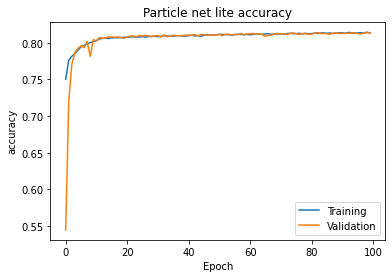

In [36]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Particle net lite accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

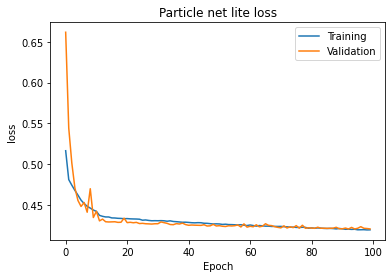

In [37]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Particle net lite loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Evaluation

In [38]:
res = model.evaluate(test_dataset, y_test)

469/469 [==============================] - 9s 18ms/step - loss: 0.5054 - accuracy: 0.7595


In [39]:
print("test loss, test acc:", res)

test loss, test acc: [0.5054326057434082, 0.7594666481018066]


## Conclusion

We built a classical GNN using Tensorflow. Considering the plots for particle net lite, the training loss decreases over epochs and also the training accuracy increases which means the model fits the data. However, the validation loss and accuracy beocmes constant after near 20th epoch which shows the overfitting. The training accuracy is near 82% which is comparable to the results of the paper [Jet tagging via particle clouds](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.101.056019). Theirs is 82.6%. One thing to note that the model takes significant amount of time for training for 10000 samples of data.